# Damped Local Trend (DLT)

In this section, we will cover:

- DLT model structure
- DLT global trend configurations
- Adding regressors in DLT
- Other configurations

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import orbit
# from orbit.template.dlt import DLTModel
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.utils.dataset import load_iclaims

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
print(orbit.__version__)

1.1.3dev


## Model Structure

**DLT** is one of the main exponential smoothing models we support in `orbit`.  Performance is benchmarked with M3 monthly, M4 weekly dataset and some Uber internal dataset [(Ng and Wang et al., 2020)](https://arxiv.org/abs/2004.08492).  The model is a fusion between the classical ETS [(Hyndman et. al., 2008)](http://www.exponentialsmoothing.net/home)) with some refinement leveraging ideas from Rlgt [(Smyl et al., 2019)](https://cran.r-project.org/web/packages/Rlgt/index.html). The model has a structural forecast equations

$$
\begin{align*}
y_t &=\mu_t + s_t + r_t +  \epsilon_t \\
\mu_t &=g_t + l_{t-1} +  \theta{b_{t-1}} \\
\epsilon_t  &~\sim \mathtt{Student}(\nu, 0, \sigma)\\
\sigma &~\sim  \mathtt{HalfCauchy}(0, \gamma_0)
\end{align*}
$$

with the update process

$$
\begin{align*}
g_t &= D(t)\\
l_t &= \rho_l(y_t - g_{t} - s_t - r_t) + (1-\rho_l)(l_{t-1} + \theta b_{t-1})\\
b_t &=  \rho_b(l_t - l_{t-1}) + (1-\rho_b)\theta b_{t-1}\\
s_{t+m} &=  \rho_s(y_t - l_t - r_t) + (1-\rho_s)s_t\\
r_t &=  \Sigma_{j}\beta_j x_{jt}
\end{align*}
$$

One important point is that using $y_t$ as a log-transformed response usually yield better result, especially we can interpret such log-transformed model as a *multiplicative form* of the original model.  Besides, there are two new additional components compared to the classical damped ETS model:

1. $D(t)$ as the deterministic trend process
2. $r$ as the regression component with $x$ as the regressors

In [4]:
# load log-transformed data
df = load_iclaims()
response_col = 'claims'
date_col = 'week'

In [6]:
import multiprocessing
multiprocessing.set_start_method("fork", force=True)

dlt = DLT(
    seasonality=52,
    seasonality_sm_input=0.1,
    level_sm_input=0.1,
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    num_warmup=4000,
    num_sample=4000,
    chains=4,
)

dlt.fit(df)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fe66aa2462adfc8a93558d083eea540a NOW.
In file included from /var/folders/g0/77v1jc9s455cj14mkqcht0m00000gn/T/pystan_9orms4lz/stanfit4anon_model_fe66aa2462adfc8a93558d083eea540a_1588068893209646009.cpp:788:
In file included from /Users/towinazure/opt/miniconda3/envs/orbit38/lib/python3.8/site-packages/numpy/core/include/numpy/arrayobject.h:5:
In file included from /Users/towinazure/opt/miniconda3/envs/orbit38/lib/python3.8/site-packages/numpy/core/include/numpy/ndarrayobject.h:12:
In file included from /Users/towinazure/opt/miniconda3/envs/orbit38/lib/python3.8/site-packages/numpy/core/include/numpy/ndarraytypes.h:1960:
/Users/towinazure/opt/miniconda3/envs/orbit38/lib/python3.8/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: "Using deprecated NumPy API, disable it with "          "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-W#warnings]
#warning "Using deprecated NumPy API, disable it with " 

In [10]:
posteriors = dlt.get_posterior_samples(permute=False)

In [11]:
posteriors['l'].shape

(4, 1000, 443)

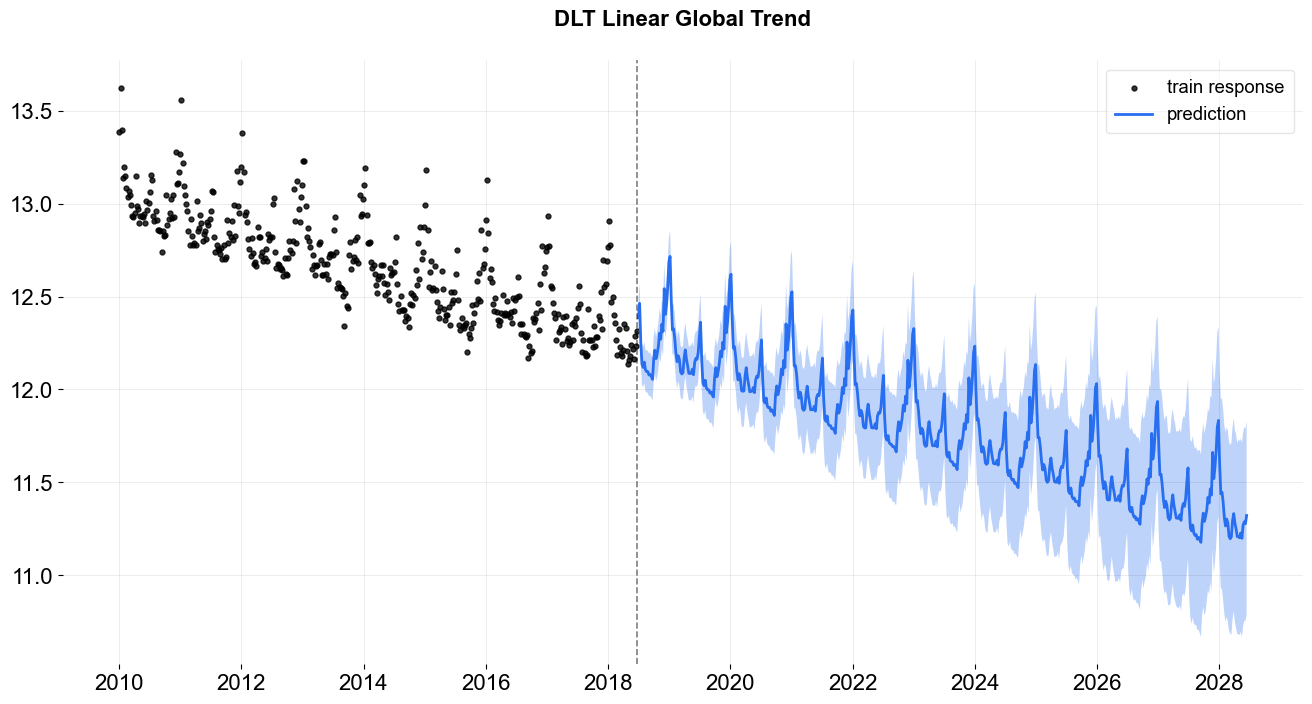

In [6]:
# test_df = dlt.make_future_df(periods=52 * 10)
# predicted_df = dlt.predict(test_df)
# predicted_df.to_csv('./data/dlt-pystan-output-test.csv', index=False)
# _ = plot_predicted_data(df, predicted_df, date_col, response_col,  title='DLT Linear Global Trend')

In [7]:
# import os
# from cmdstanpy import CmdStanModel

# stan_file="/Users/towinazure/edwinnglabs/orbit/orbit/stan/dlt.stan"

# model = CmdStanModel(stan_file=stan_file)

# import pickle
# with open("../orbit/stan_compiled/dlt_cmdstan.pkl", "wb") as f:
#     pickle.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
# import pickle
# with open("../orbit/stan_compiled/dlt_cmdstan.pkl", "rb") as f:
#     model = pickle.load(f)
# training_data = dlt.get_training_data_input()
# training_data.keys()
# training_data.update({"T_STAR": 1.0})
# fit = model.optimize(
#     data=training_data,
#     algorithm="LBFGS",
# )
# fit = model.sample(data=training_data)

In [9]:
# posteriors.keys()
# posteriors = fit.stan_variables()
# posteriors

In [10]:
# from orbit.template.dlt import DLTModel
# from orbit.estimators.cmdstan_estimator import CmdStanEstimatorMAP, CmdStanEstimatorMCMC
# from orbit.forecaster import MAPForecaster, FullBayesianForecaster
# dlt_mod = DLTModel(
#     seasonality=52,
#     seasonality_sm_input=0.1,
#     level_sm_input=0.1,
# )


# dlt_forecaster = FullBayesianForecaster(
#     model=dlt_mod, 
#     response_col=response_col,
#     date_col=date_col,
#     estimator_type=CmdStanEstimatorMCMC,  
# )
# dlt_forecaster.fit(df)
# test_df = dlt_forecaster.make_future_df(periods=52 * 10)
# predicted_df = dlt_forecaster.predict(test_df)
# _ = plot_predicted_data(df, predicted_df, date_col, response_col,  title='DLT Linear Global Trend')

In [7]:
dlt = DLT(
    seasonality=52,
    seasonality_sm_input=0.1,
    level_sm_input=0.1,
    response_col=response_col,
    date_col=date_col,
    estimator='cmdstan-mcmc',
    num_warmup=4000,
    num_sample=4000,
    chains=4,
)
dlt.fit(df)

16:10:11 - cmdstanpy - INFO - Requested 8 parallel_chains but only 4 required, will run all chains in parallel.
16:10:11 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:10:25 - cmdstanpy - INFO - CmdStan done processing.


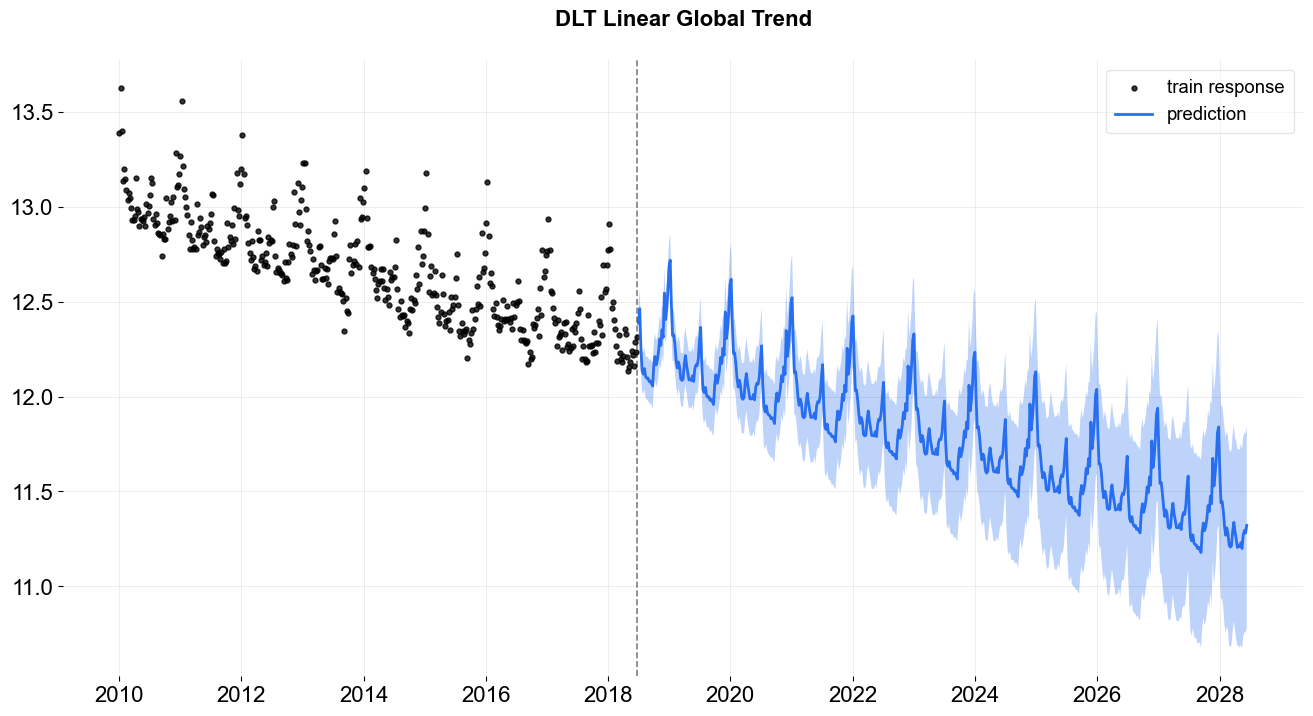

In [8]:
test_df = dlt.make_future_df(periods=52 * 10)
predicted_df = dlt.predict(test_df)
predicted_df.to_csv('./data/dlt-cmdstan-output-test.csv', index=False)
_ = plot_predicted_data(df, predicted_df, date_col, response_col,  title='DLT Linear Global Trend')